# Step 1: Data Preprocessing

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Loading dataset
crop = pd.read_csv('Dataset/Crop.csv')

# Encoding the labels (crop)
label_encoder = LabelEncoder()
crop['label'] = label_encoder.fit_transform(crop['label'])

# Standardizing numerical features
# Scale the features so that each feature has a mean of 0 and a standard deviation of 1. To reduce the dominace of a single feature
scaler = StandardScaler()
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
crop[features] = scaler.fit_transform(crop[features]) 

# Step 2: Data Analysis

### 1.	Correlation Heatmap: Feature relationships

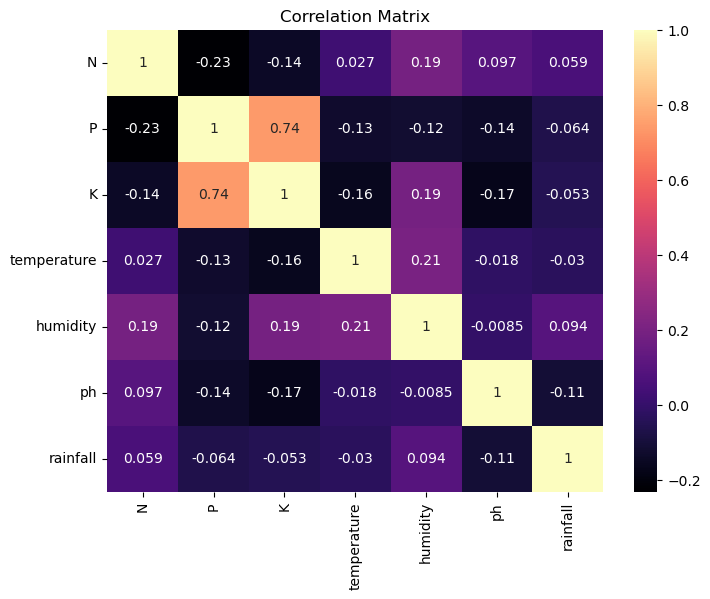

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(crop[features].corr(), annot=True, cmap='magma')
plt.title('Correlation Matrix')
plt.show()

### 2.	Pairplot: Feature relationships and check class separability

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/kevil/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


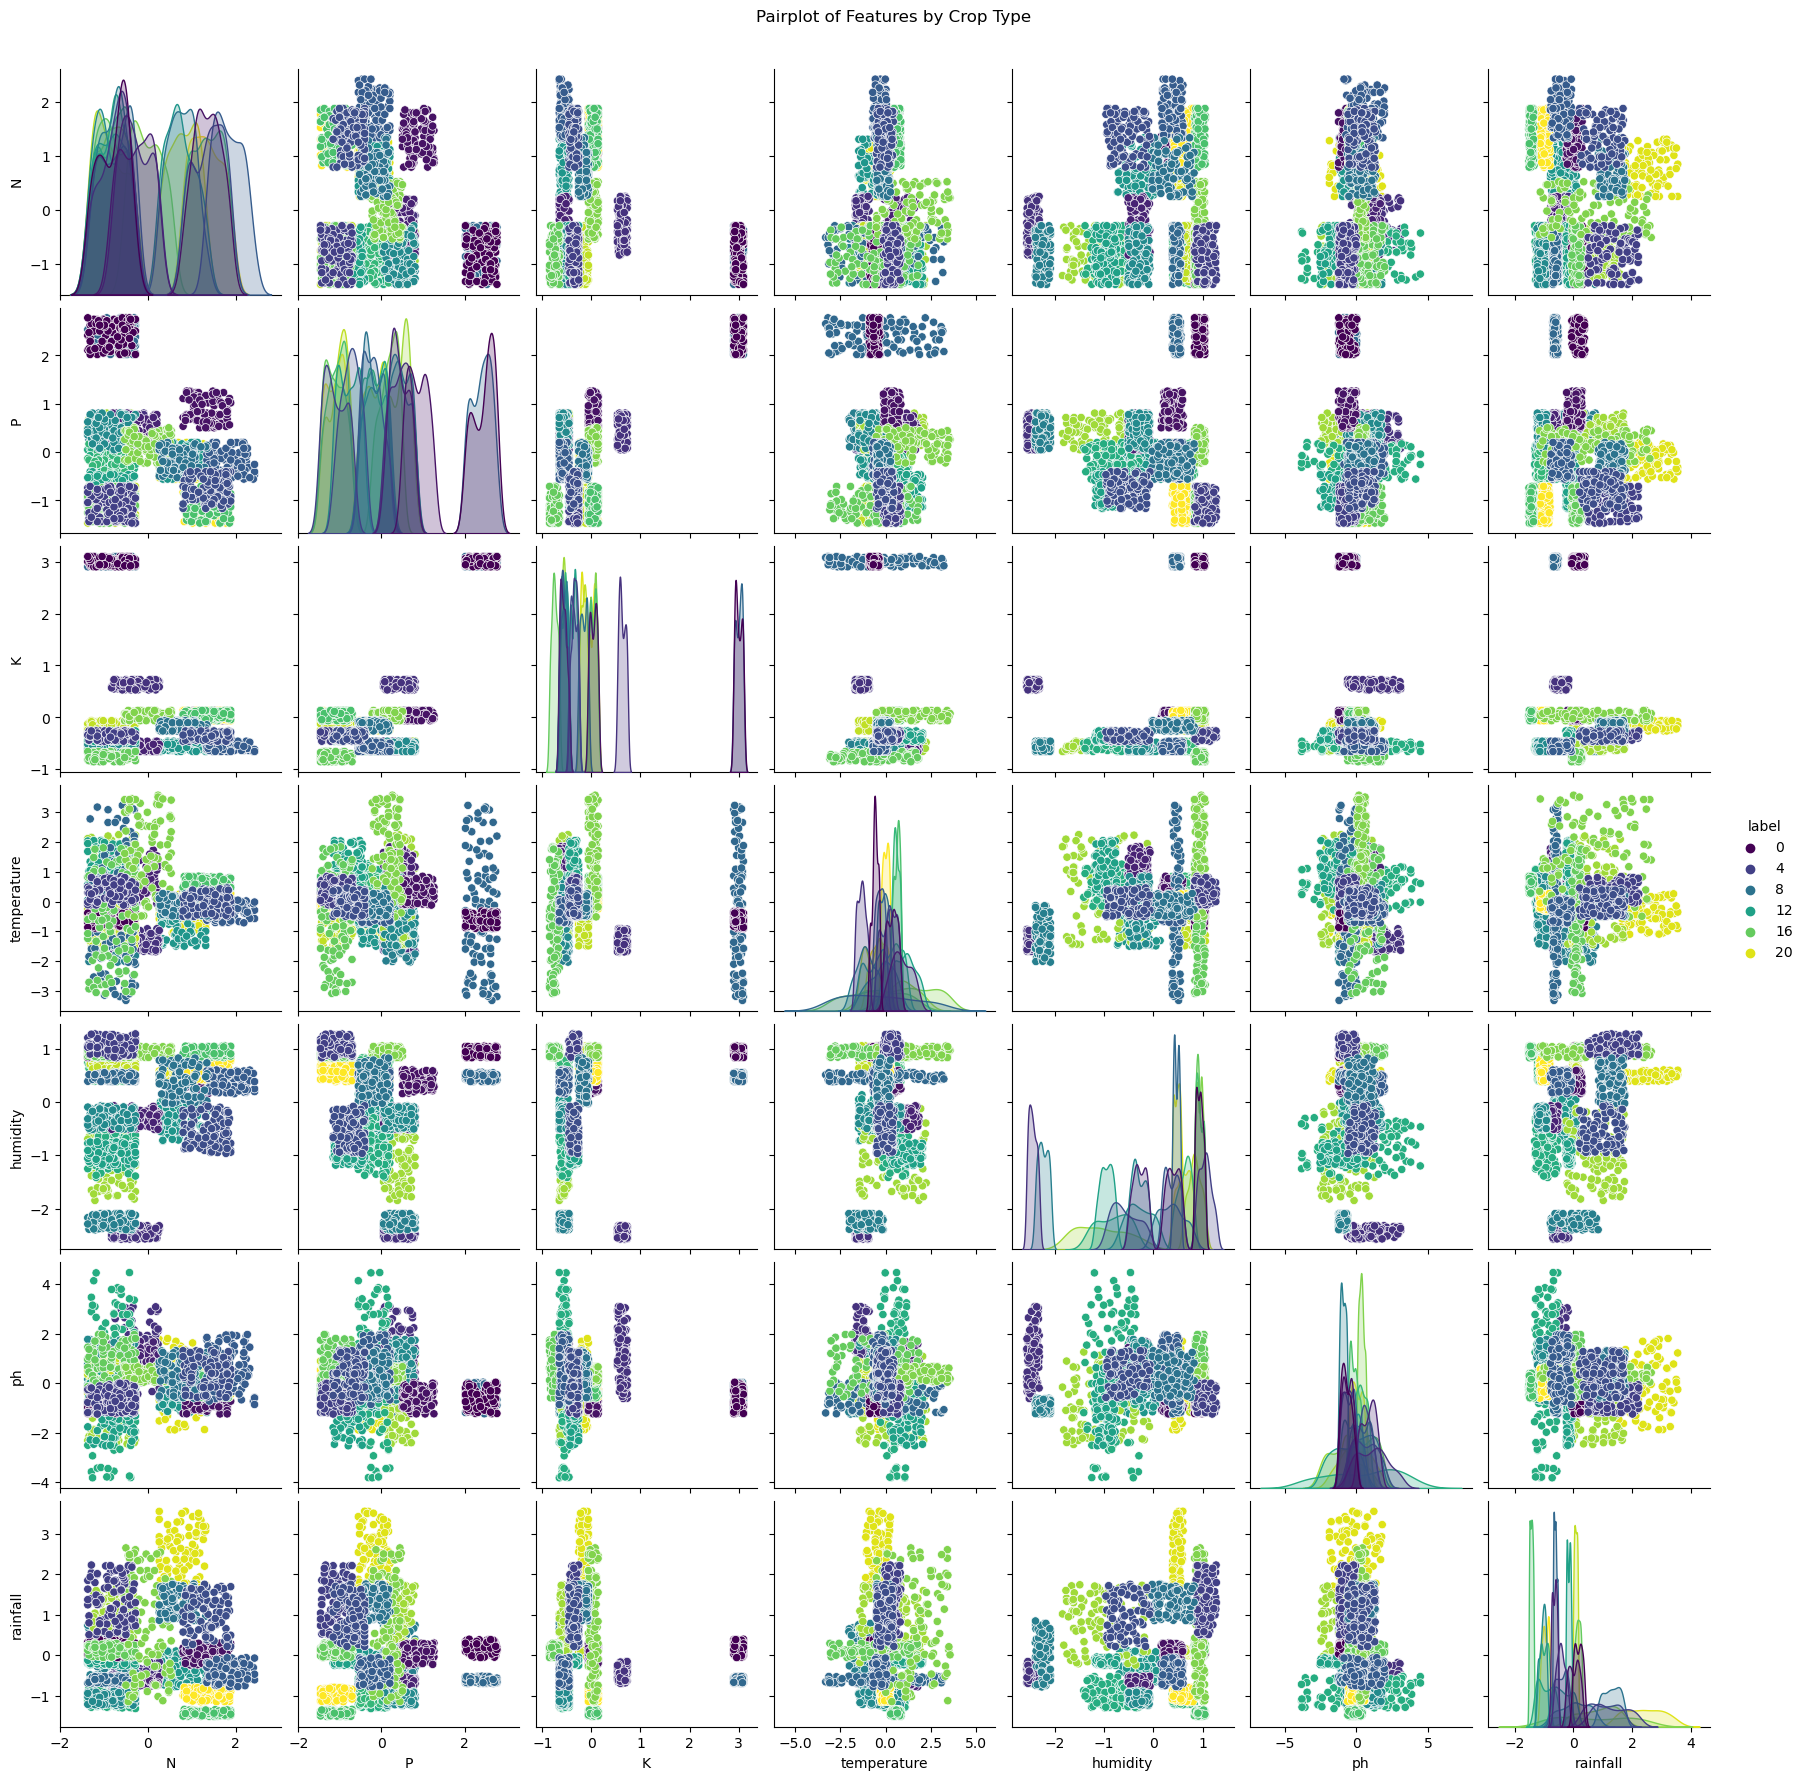

In [3]:
sns.pairplot(crop, hue='label', vars=features, palette="viridis")
plt.suptitle("Pairplot of Features by Crop Type", y=1.02)
plt.show()

### 3.	Class Distribution: How each crop type is distributed in the dataset.

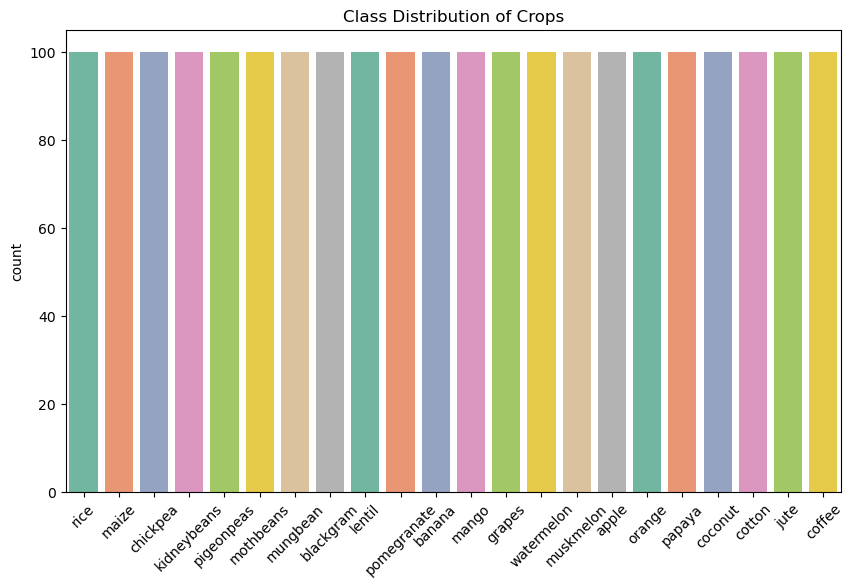

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x=label_encoder.inverse_transform(crop['label']), palette="Set2")
plt.title("Class Distribution of Crops")
plt.xticks(rotation=45)
plt.show()

# Step 3: Model Training

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Split data
X = crop[features]
y = crop['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300], #number of trees in the random forest
    'max_depth': [10, 20, 30], #maximum depth of each tree in the forest
    'min_samples_split': [2, 5, 10] #minimum number of samples required to split an internal node
}
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
# grid search automates the process of tuning hyperparameters by trying different combinations and selects the best one based on model performance
# cv : technique used to evaluate the performance of a machine learning model by training it on different subsets of the dataset and testing it on the remaining unseen data
# cv = 5 : splitting the data into 5 equal parts(folds)
# n_jobs=-1 means that the grid search will use all available cores to perform the search in parallel
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Step 4: Model Evaluation

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Model prediction
y_pred = best_rf.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        14
      papaya       1.00    

<Figure size 1000x800 with 0 Axes>

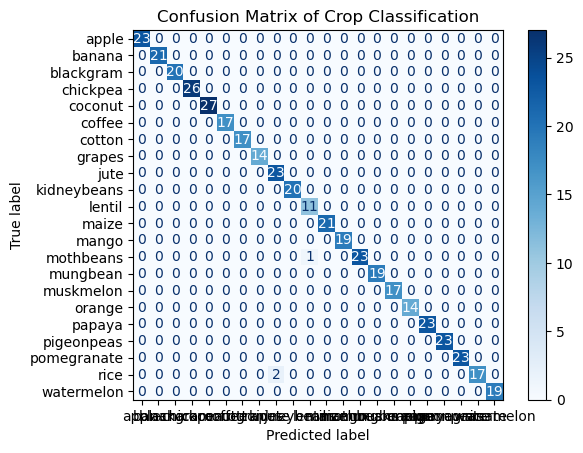

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix of Crop Classification")
plt.show()

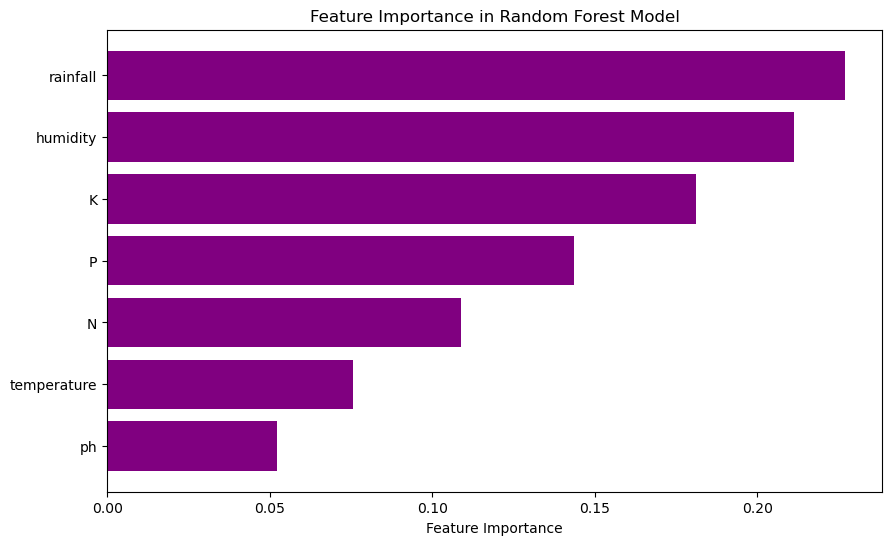

In [8]:
# Feature Importance Visualization
feature_importance = best_rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx], color='purple')
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest Model")
plt.show()

### 2.	Precision-Recall Curve: Good for datasets with class imbalance.

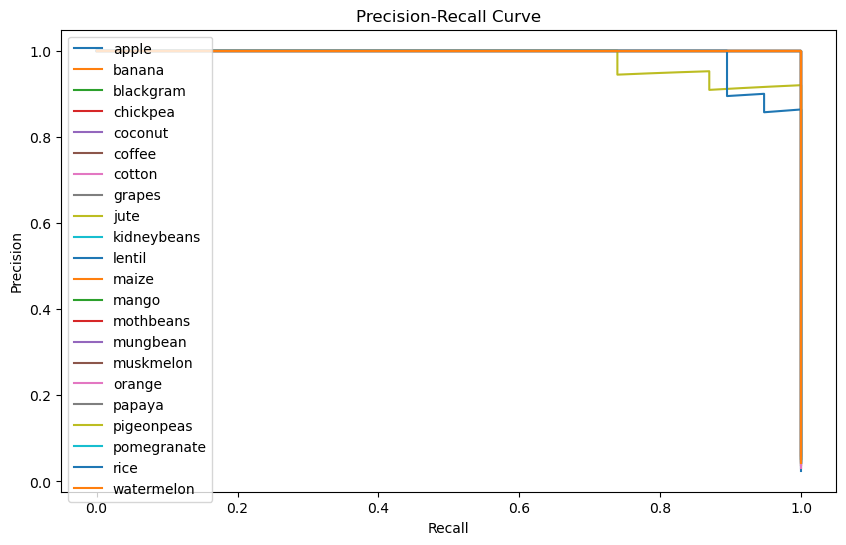

In [9]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10, 6))
for i, crop_name in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test == i, best_rf.predict_proba(X_test)[:, i])
    plt.plot(recall, precision, label=crop_name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# A high precision indicates that the model has a low rate of false positives
# A high recall indicates that the model has a low rate of false negatives
# good model = high precision + high recall